In [175]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import torch

Define all seeds and setup variables

In [176]:
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

In [177]:
data = pd.read_csv('clean_combined_final.csv')

## Split and Normalize data

In [178]:
features = ["SigC", "SigH", "EpsC", "EpsH"]
target = "density"

X = data[features]
y = data[target]

In [179]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# save scalers for inference
joblib.dump(feature_scaler, "feature_scaler.joblib")
joblib.dump(target_scaler, "target_scaler.joblib")

['target_scaler.joblib']

sizes:  train: 5245 test: 1312

Feature summary (train):


,SigC,SigH,EpsC,EpsH
count,5245.000000,5245.000000,5245.000000,5245.000000
mean,0.201728,0.167117,0.658460,0.079846
std,0.090331,0.075956,0.297145,0.037779
min,0.050000,0.045149,0.150977,0.010068
25%,0.125000,0.100103,0.410800,0.047723
50%,0.200000,0.163694,0.657200,0.080000
75%,0.276758,0.227500,0.903700,0.110980
max,0.350000,0.347617,1.150100,0.149932



Feature summary (test):


,SigC,SigH,EpsC,EpsH
count,1312.000000,1312.000000,1312.000000,1312.000000
mean,0.201465,0.166897,0.651418,0.078936
std,0.091280,0.075641,0.298598,0.037456
min,0.050000,0.045500,0.153418,0.010342
25%,0.123330,0.097295,0.407549,0.048232
50%,0.200000,0.160291,0.657200,0.080000
75%,0.276511,0.227500,0.903700,0.110000
max,0.350000,0.336299,1.150100,0.149521



Target summary (train / test):


,train,test
count,5245.000000,1312.000000
mean,673.824100,675.111587
std,94.831589,93.344209
min,301.658000,307.718000
25%,644.642000,644.505750
50%,667.192000,666.188000
75%,715.968000,718.653500
max,939.206000,928.911000


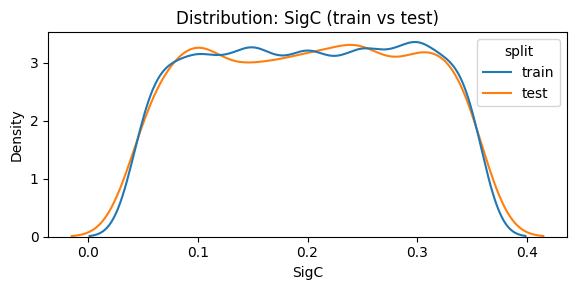

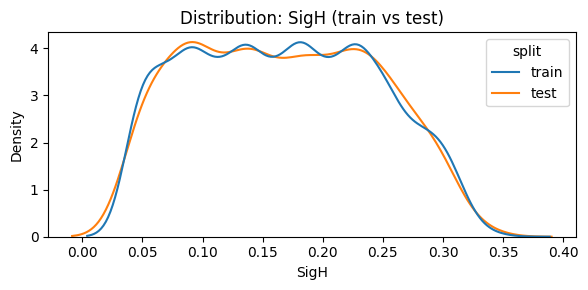

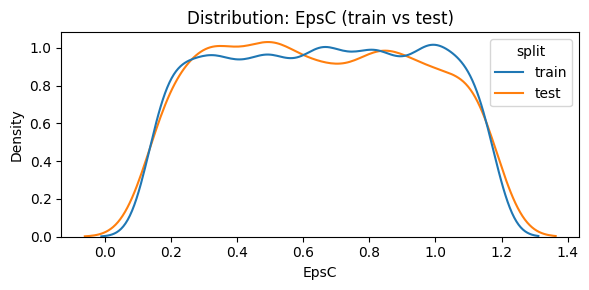

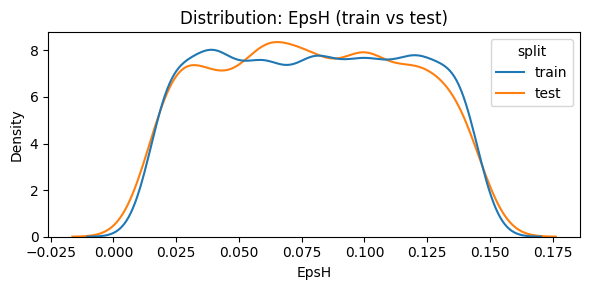

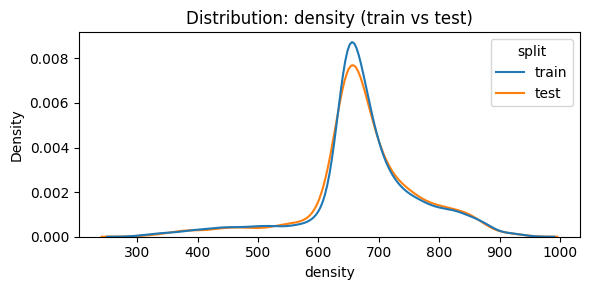

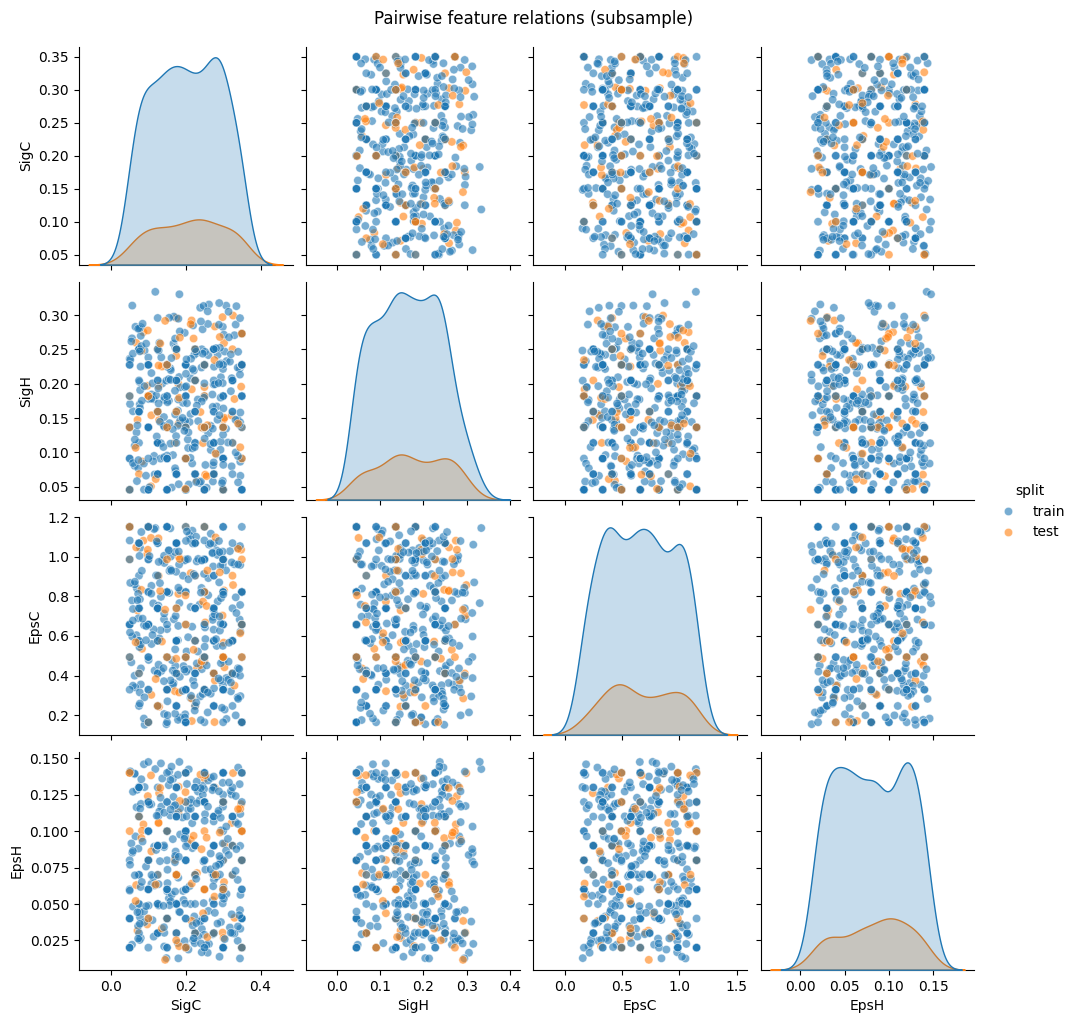

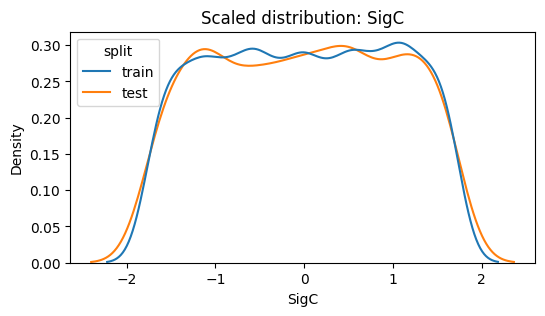

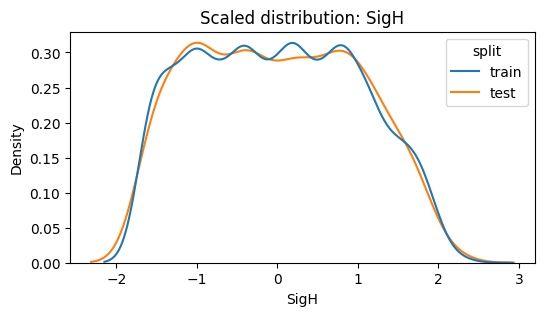

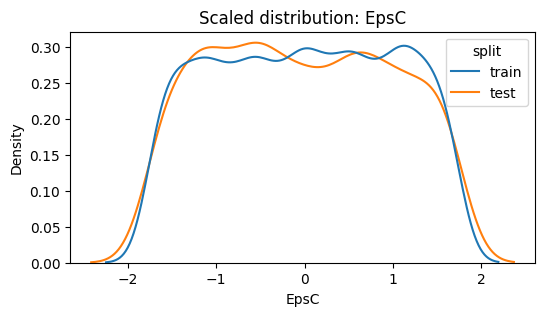

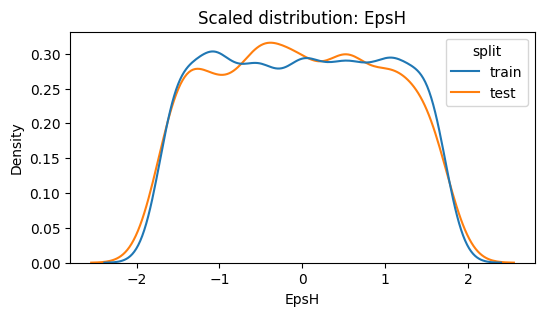

In [180]:
# inspect train / test distributions (original and scaled)
import matplotlib.pyplot as plt
import seaborn as sns

print("sizes: ", "train:", len(X_train), "test:", len(X_test))
print("\nFeature summary (train):")
display(X_train.describe())
print("\nFeature summary (test):")
display(X_test.describe())
print("\nTarget summary (train / test):")
display(pd.DataFrame({"train": y_train.describe(), "test": y_test.describe()}))

# combine for plotting
df_tr = X_train.copy()
df_tr[target] = y_train
df_tr["split"] = "train"
df_te = X_test.copy()
df_te[target] = y_test
df_te["split"] = "test"
df_comb = pd.concat([df_tr, df_te], ignore_index=True)

# plot KDEs for each feature and the target
cols = features + [target]
for c in cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df_comb, x=c, hue="split", common_norm=False, fill=False)
    plt.title(f"Distribution: {c} (train vs test)")
    plt.tight_layout()
    plt.show()

# optional: pairplot on a small random subsample (can be slow)
sample = df_comb.sample(min(500, len(df_comb)), random_state=0)
sns.pairplot(sample, vars=features, hue="split", plot_kws={"alpha":0.6}, diag_kind="kde")
plt.suptitle("Pairwise feature relations (subsample)", y=1.02)
plt.show()

# also check distributions on scaled data if needed
Xtr_s = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
Xte_s = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)
df_s = pd.concat([
    Xtr_s.assign(split="train"),
    Xte_s.assign(split="test")
]).reset_index(drop=True)

for c in features:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df_s, x=c, hue="split", common_norm=False)
    plt.title(f"Scaled distribution: {c}")
    plt.show()

## Baseline: Neuronales Netz zur Dichtevorhersage

### Zielsetzung

Ziel dieses Experiments ist es, ein **Baseline-Surrogatmodell** zu trainieren, das die durch Molekulardynamik-Simulationen berechnete Dichte als Funktion der Lennard-Jones-Parameter vorhersagt.  
Dieses Baseline-Modell dient später als **Referenz** für weiterführende Untersuchungen, insbesondere für Active-Learning-Strategien.

---

### Eingangs- und Zielgrößen

Als Eingangsparameter (Features) werden vier Lennard-Jones-Parameter verwendet:

- σ<sub>C</sub> (`SigC`)
- σ<sub>H</sub> (`SigH`)
- ε<sub>C</sub> (`EpsC`)
- ε<sub>H</sub> (`EpsH`)

Die Zielgröße ist:

- Dichte (`density`)

Damit wird ein **nichtlinearer Regressionszusammenhang** zwischen dem Parameterraum und der resultierenden Dichte modelliert.

---

### Datensplit

Der Datensatz wird zufällig in Trainings- und Testdaten aufgeteilt:

- **80 % Trainingsdaten**
- **20 % Testdaten**

Der Testdatensatz wird ausschließlich zur abschließenden Evaluation verwendet und während des Trainings nicht zur Modellanpassung herangezogen.

---

### Datenvorverarbeitung

Da neuronale Netze sensitiv auf unterschiedliche Skalen der Eingangsgrößen reagieren, werden sowohl Features als auch Zielgröße standardisiert:

- Mittelwert = 0
- Standardabweichung = 1

Wichtig dabei:
- Die Skalierer werden **ausschließlich auf den Trainingsdaten gefittet**
- Testdaten werden nur transformiert

Dies verhindert Datenleckage und gewährleistet eine saubere Evaluation.

Die Skalierer werden zusätzlich gespeichert, um eine konsistente Inferenz in späteren Experimenten zu ermöglichen.

---

### Modellarchitektur

Als Surrogatmodell wird ein vollständig verbundenes neuronales Netz (Multilayer Perceptron) verwendet:

- Eingabeschicht: 4 Neuronen
- Versteckte Schichten: 16 → 32 → 8 Neuronen
- Aktivierungsfunktion: ReLU
- Ausgabeschicht: 1 Neuron (Dichte)

Die Architektur wurde bewusst einfach gehalten und wird in allen weiteren Experimenten unverändert verwendet, um eine vergleichbare Bewertung verschiedener Trainingsstrategien zu ermöglichen.

---

### Training

Das Modell wird mit folgenden Einstellungen trainiert:

- Verlustfunktion: Mean Squared Error (MSE)
- Optimierer: Adam
- Lernrate: 1e-3
- Batch-Größe: 32
- Epochen: 100

Während des Trainings wird der MSE auf den Trainingsdaten sowie auf dem Testdatensatz überwacht.

---

### Evaluation

Nach dem Training werden die Vorhersagen des Modells auf dem Testdatensatz berechnet.  
Zur besseren physikalischen Interpretierbarkeit werden die vorhergesagten Dichten **in die Originaleinheiten zurücktransformiert**.

Als finale Bewertungsmetrik wird der **Root Mean Squared Error (RMSE)** im Originalmaßstab der Dichte verwendet.

Dieses Ergebnis dient als **Baseline-Performance**, gegen die später Active-Learning-Ansätze verglichen werden.


In [181]:
model = net = torch.nn.Sequential(
    torch.nn.Linear(len(features), 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 1)
)

In [182]:
model = model.to(device)

In [183]:
import torch.utils.data as data_utils
from sklearn.metrics import mean_squared_error

# prepare tensors / dataloaders
X_tr = torch.tensor(X_train_scaled.values.astype(np.float32))
y_tr = torch.tensor(y_train_scaled.astype(np.float32)).unsqueeze(1)  # shape (N,1)
X_te = torch.tensor(X_test_scaled.values.astype(np.float32))
y_te = torch.tensor(y_test_scaled.astype(np.float32)).unsqueeze(1)

# optional: quick shape check
print("X_tr, y_tr shapes:", X_tr.shape, y_tr.shape)
print("X_te, y_te shapes:", X_te.shape, y_te.shape)

train_ds = data_utils.TensorDataset(X_tr, y_tr)
train_loader = data_utils.DataLoader(train_ds, batch_size=32, shuffle=True)

# loss, optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# training loop
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_ds)

    # validation: use y_te (tensor) so lengths match
    model.eval()
    with torch.no_grad():
        X_te_device = X_te.to(device)
        preds_te = model(X_te_device).cpu().numpy().ravel()
        y_te_np = y_te.cpu().numpy().ravel()
        # sanity check
        assert preds_te.shape[0] == y_te_np.shape[0], f"preds {preds_te.shape[0]} vs labels {y_te_np.shape[0]}"
        val_loss = mean_squared_error(y_te_np, preds_te)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} train_mse={train_loss:.6f} val_mse={val_loss:.6f}")

# save model
torch.save(model.state_dict(), "surrogate_model.pt")

# inverse-transform test predictions to original units
model.eval()
with torch.no_grad():
    preds_scaled = model(X_te.to(device)).cpu().numpy()  # shape (N,1) or (N,)
# ensure correct shape for inverse_transform (2D)
preds_scaled = preds_scaled.reshape(-1, 1)
preds_orig = target_scaler.inverse_transform(preds_scaled)  # shape (N,1)
# compare with y_test (original)
y_test_orig = y_test.values.reshape(-1, 1)
print("Test RMSE (original units):", np.sqrt(mean_squared_error(y_test_orig, preds_orig)))

X_tr, y_tr shapes: torch.Size([5245, 4]) torch.Size([5245, 1])
X_te, y_te shapes: torch.Size([1312, 4]) torch.Size([1312, 1])
Epoch   1 train_mse=0.830359 val_mse=0.622080
Epoch  10 train_mse=0.092206 val_mse=0.075322
Epoch  20 train_mse=0.036035 val_mse=0.022356
Epoch  30 train_mse=0.027661 val_mse=0.015241
Epoch  40 train_mse=0.026374 val_mse=0.012479
Epoch  50 train_mse=0.025720 val_mse=0.013060
Epoch  60 train_mse=0.025192 val_mse=0.011945
Epoch  70 train_mse=0.024968 val_mse=0.013160
Epoch  80 train_mse=0.024795 val_mse=0.010674
Epoch  90 train_mse=0.024319 val_mse=0.011731
Epoch 100 train_mse=0.024256 val_mse=0.013461
Test RMSE (original units): 11.001290482312662


## Active Learning

### Datensplit für Active Learning

Der Gesamtdatensatz wird in vier disjunkte Teilmengen aufgeteilt, um eine saubere Trennung zwischen Training, Modellsteuerung und Evaluation zu gewährleisten.

- **Testset (15 %):**  
  Wird einmalig zu Beginn definiert und ausschließlich zur finalen Bewertung der Modellperformance verwendet.

- **Validation Set (10 %):**  
  Dient der internen Bewertung während des Active-Learning-Prozesses (z. B. Überwachung des Lernfortschritts, Stabilität des Modells).  
  Es wird weder für das Training noch für die finale Evaluation genutzt.

- **Initiales Trainingsset D₀ (~15 %):**  
  Startmenge für das erste Surrogatmodell.

- **Pool (~60 %):**  
  Enthält die verbleibenden Datenpunkte, aus denen iterativ neue Trainingspunkte im Rahmen des Active Learnings ausgewählt werden.

Diese Aufteilung bleibt für alle folgenden Experimente unverändert.


In [184]:
size_test = 0.15
size_pool_full = 1 - size_test
size_init_train = 0.005
size_valid = 0.1
size_pool = size_pool_full - size_valid - size_init_train
random_state = seed = 42

1. Split to Pool and Testset

In [185]:
X = data[features]
y = data[target]

X_active, X_test, y_active, y_test = train_test_split(
    X, y,
    test_size=size_test,
    random_state=random_state,
    shuffle=True
)

2. Split Pool and Validationset

In [186]:
X_pool_full, X_val, y_pool_full, y_val = train_test_split(
    X_active, y_active,
    test_size=(size_valid / size_pool_full),
    random_state=random_state,
    shuffle=True
)

3. Split Pool and initial Trainingset

In [187]:
X_train, X_pool, y_train, y_pool = train_test_split(
    X_pool_full, y_pool_full,
    train_size=(size_init_train/size_pool_full),
    random_state=random_state,
    shuffle=True
)

In [188]:
print("Train:", len(X_train), f"({len(X_train)/len(data):.2%})")
print("Pool:", len(X_pool), f"({len(X_pool)/len(data):.2%})")
print("Validation:", len(X_val), f"({len(X_val)/len(data):.2%})")
print("Test:", len(X_test), f"({len(X_test)/len(data):.2%})")
print("Summe:", len(X_train) + len(X_pool) + len(X_val) + len(X_test))
print("Gesamt:", len(data))

Train: 28 (0.43%)
Pool: 4889 (74.56%)
Validation: 656 (10.00%)
Test: 984 (15.01%)
Summe: 6557
Gesamt: 6557


### Welche Datensätze habe ich nun?

- X_train, y_train   → Initiales Training D₀

- X_pool, y_pool     → Pool für Active Learning

- X_val, y_val       → Validation Set

- X_test, y_test     → Finales Testset

### Skaliere/Transformiere die Daten, soweit möglich

1. Scaler initialisieren

In [189]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

2. Training --> fit + transform

In [190]:
# Features
X_train_scaled = feature_scaler.fit_transform(X_train)

# Target (reshape nötig für sklearn)
y_train_scaled = target_scaler.fit_transform(
    y_train.values.reshape(-1, 1)
).ravel()

3. Validation --> nur transformieren

In [191]:
X_val_scaled = feature_scaler.transform(X_val)

y_val_scaled = target_scaler.transform(
    y_val.values.reshape(-1, 1)
).ravel()

4. Pool --> nur transformieren

In [192]:
X_pool_scaled = feature_scaler.transform(X_pool)

5. Test --> nur transformieren

In [193]:
X_test_scaled = feature_scaler.transform(X_test)

y_test_scaled = target_scaler.transform(
    y_test.values.reshape(-1, 1)
).ravel()

Funktion, um in jeder Iteration des Active Learning Prozesses die Daten richtig zu skalieren und transformieren.

In [194]:
def scale_data(X_train, y_train, X_val, y_val, X_pool, X_test, y_test):
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train_s = feature_scaler.fit_transform(X_train)
    y_train_s = target_scaler.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    X_val_s = feature_scaler.transform(X_val)
    y_val_s = target_scaler.transform(
        y_val.values.reshape(-1, 1)
    ).ravel()

    X_pool_s = feature_scaler.transform(X_pool)

    X_test_s = feature_scaler.transform(X_test)
    y_test_s = target_scaler.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    return (
        X_train_s, y_train_s,
        X_val_s, y_val_s,
        X_pool_s,
        X_test_s, y_test_s,
        feature_scaler, target_scaler
    )

Funktion, um später von transformierten Vorhersagen auf physiklisch interpretierbare Werte zurückschließen zu können.

Vorhersage: `y_pred_scaled = model(X_test_tensor).cpu().numpy()`

In [195]:
def inverse_transform_prediction(y_pred_scaled, target_scaler):
    y_pred = target_scaler.inverse_transform(
        y_pred_scaled.reshape(-1, 1)
    ).ravel()
    return y_pred

### Trainings- und Evaluationszyklus

In [196]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset


def build_model(input_dim: int):
    return torch.nn.Sequential(
        torch.nn.Linear(input_dim, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 8),
        torch.nn.ReLU(),
        torch.nn.Linear(8, 1),
    )


def train_and_evaluate(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    *,
    n_epochs=100,
    batch_size=32,
    lr=1e-3,
    seed=seed,
    device=None,
):
    # -------------------------
    # Reproducibility
    # -------------------------
    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # -------------------------
    # Scaling (FIT ONLY ON TRAIN)
    # -------------------------
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train_s = feature_scaler.fit_transform(X_train)
    y_train_s = target_scaler.fit_transform(
        y_train.values.reshape(-1, 1)
    ).ravel()

    X_val_s = feature_scaler.transform(X_val)
    y_val_s = target_scaler.transform(
        y_val.values.reshape(-1, 1)
    ).ravel()

    X_test_s = feature_scaler.transform(X_test)
    y_test_s = target_scaler.transform(
        y_test.values.reshape(-1, 1)
    ).ravel()

    # -------------------------
    # Torch datasets
    # -------------------------
    X_tr = torch.tensor(X_train_s, dtype=torch.float32)
    y_tr = torch.tensor(y_train_s, dtype=torch.float32).unsqueeze(1)

    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True
    )

    # -------------------------
    # Model & optimizer
    # -------------------------
    model = build_model(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    # -------------------------
    # Training loop
    # -------------------------
    for _ in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = loss_fn(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # -------------------------
    # Evaluation
    # -------------------------
    model.eval()
    with torch.no_grad():
        # Validation
        X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
        val_preds_s = model(X_val_t).cpu().numpy().ravel()
        val_rmse = np.sqrt(mean_squared_error(y_val_s, val_preds_s))

        # Test (original scale!)
        X_test_t = torch.tensor(X_test_s, dtype=torch.float32).to(device)
        test_preds_s = model(X_test_t).cpu().numpy()
        test_preds = target_scaler.inverse_transform(test_preds_s).ravel()

        test_rmse = np.sqrt(mean_squared_error(y_test.values, test_preds))

    return {
        "model": model,
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler,
        "val_rmse_scaled": val_rmse,
        "test_rmse": test_rmse,
    }

In [197]:
train_and_evaluate(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    n_epochs=100,
    batch_size=32,
    lr=1e-3,
    seed=42
)

{'model': Sequential(
   (0): Linear(in_features=4, out_features=16, bias=True)
   (1): ReLU()
   (2): Linear(in_features=16, out_features=32, bias=True)
   (3): ReLU()
   (4): Linear(in_features=32, out_features=8, bias=True)
   (5): ReLU()
   (6): Linear(in_features=8, out_features=1, bias=True)
 ),
 'feature_scaler': StandardScaler(),
 'target_scaler': StandardScaler(),
 'val_rmse_scaled': np.float64(0.5656508356108058),
 'test_rmse': np.float64(72.60556613016574)}

### Auswahlkriterien

Zur Auswahl stehen folgende Kriterien:

#### 1. **Random Sampling**

Dieses Verfahren dient als Baseline. Es werden zufällig Punkte aus dem Pool gewählt, die in der nächsten Iteration in das Trainingsset aufgenommen werden.

#### 2. **Geometrisch**

- **2.1 Randbereich Sampling (Boundary Sampling)**

    - Man nehme die oberen/unteren 5 bis 10% der Parameterräume und fügt diese iterativ hinzu

- **2.2 Sparse Samling (Maximin/Distance-based)**

    - Wähle die Punkte mit den größten Abständen zu den bisherigen Trainingspunkten

    - ignoriert Zielgößen

- **2.3 Grid/Latin Hypercube/Sobol Re-Sampling**

    - füllt systematisch "Lücken" im Raum

#### 3. **Modellbasierte Strategien**

- **3.1 Error-based Sampling**

    - Wähle Punkte, bei denen das Modell schlecht ist

    - Fehler/zugehörige Punkte werden über den Validationsset ausgewählt

- **3.2 Gradient/Sensitivity-based Sampling**

    - Wo ändert sich die Vorhersage stark bei kleinen Parameteränderungen?

    - Erkennung komplexer Regionen

#### 4. **Ensemble-/Stabilitätsbasierte Strategien**

- **4.1 Query-by-Committee (QBC)**

    - Behalte mehrere Hypothesen und untersuche, wo Uneinigkeiten auftreten

    - Trainiere verschiedene Modelle und wähle Punkte mit hoher Vorhersage-Streuung

    - höhere Rechenkosten

- **4.2 Seed-Variance Sampling (Subset von QBC)**

    - Trainiere gleiche Architekturen  mit unterschiedlichen Initalisierungen

#### 5. **Hybrid**

Kombiniere verschiedene Auswahlstrategien. Auch aus unterschiedlichen Kategorien, um ein besseres Gesamtsystem zu erhalten.

#### Vergleich der Auswahlkriterien

| Strategie   | Typ           | Nutzung        |
| ----------- | ------------- | -------------- |
| Random      | Baseline      | Pflicht        |
| Boundary    | Geometrisch   | Exploration    |
| Sparse      | Geometrisch   | Exploration    |
| Error-based | Modellbasiert | Schwächenfokus |
| QBC         | Modellbasiert | Unsicherheit   |

How to use (Beispiel: Random Sample):

```python
X_new, y_new, X_pool, y_pool = sample_random(
    X_pool, y_pool,
    k=25,
    seed=seed
)

X_train = pd.concat([X_train, X_new])
y_train = pd.concat([y_train, y_new])
```

#### Random Sampling

Wählt zufällig `k`-viele Punkte aus dem Pool

In [198]:
def sample_random(X_pool, y_pool, k, seed=None):
    """
    Randomly sample k data points from the pool.

    Parameters
    ----------
    X_pool : pd.DataFrame
        Pool feature data.
    y_pool : pd.Series
        Pool target data.
    k : int
        Number of samples to draw.
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    X_new : pd.DataFrame
        Selected feature samples.
    y_new : pd.Series
        Selected target samples.
    X_pool_remaining : pd.DataFrame
        Pool after removing selected samples.
    y_pool_remaining : pd.Series
        Pool targets after removing selected samples.
    """
    if k > len(X_pool):
        raise ValueError("k must be smaller than pool size")

    X_new = X_pool.sample(n=k, random_state=seed)
    y_new = y_pool.loc[X_new.index]

    X_pool_remaining = X_pool.drop(X_new.index)
    y_pool_remaining = y_pool.drop(X_new.index)

    return X_new, y_new, X_pool_remaining, y_pool_remaining

#### Randbereich Sampling

Ein Punkt ist Randpunkt, wenn mindestens ein Feature im unteren oder oberen Quantil (5%) liegt. Falls mehr als `k`-viele Randpunkte existieren, wird zufällig aus diesen gewählt, sonst alle.

Diese Strategie ist rein geometrisch motiviert und adressiert gezielt Rand- und Extrembereiche, die für Surrogatmodelle besonders herausfordernd sind.

Erweiterbar:

- Progressive Randbereiche. Mit laufender Iteration den Randbereich verkleinern (20 --> 1%)

- statt mindestens ein Feature, müssen alle Feature im Randbereich liegen (`.all(axis=1)`)

In [199]:
def sample_boundary(X_pool, y_pool, k, quantile=0.05, seed=None):
    """
    Sample points from the boundary of the parameter space.

    A point is considered a boundary point if at least one feature
    lies below the lower quantile or above the upper quantile.

    Parameters
    ----------
    X_pool : pd.DataFrame
        Pool feature data.
    y_pool : pd.Series
        Pool target data.
    k : int
        Number of samples to draw.
    quantile : float
        Fraction defining the boundary (e.g. 0.05 for 5%).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    X_new, y_new, X_pool_remaining, y_pool_remaining
    """
    if k > len(X_pool):
        raise ValueError("k must be smaller than pool size")

    # compute quantile thresholds
    lower_bounds = X_pool.quantile(quantile)
    upper_bounds = X_pool.quantile(1 - quantile)

    # identify boundary points
    is_boundary = (
        (X_pool <= lower_bounds) | (X_pool >= upper_bounds)
    ).any(axis=1)

    X_boundary = X_pool[is_boundary]
    y_boundary = y_pool.loc[X_boundary.index]

    # if more boundary points than needed --> random subset
    if len(X_boundary) > k:
        X_new = X_boundary.sample(n=k, random_state=seed)
        y_new = y_boundary.loc[X_new.index]
    else:
        X_new = X_boundary
        y_new = y_boundary

    # remove selected points from pool
    X_pool_remaining = X_pool.drop(X_new.index)
    y_pool_remaining = y_pool.drop(X_new.index)

    return X_new, y_new, X_pool_remaining, y_pool_remaining


#### Sparse Sampling

Beim Sparse Sampling werden gezielt Datenpunkte ausgewählt, die im Parameterraum möglichst weit von den bisherigen Trainingspunkten entfernt liegen.

Für jeden Punkt $x \in X_{pool}$:

$$
d(x) = \min_{x' \in X_{train}} || x - x' ||
$$

Wähle die `k` Punkte mit dem größten $d(x)$

Distanzen sind jedoch nur sinnvoll im skaliertem Raum, da die Feautures unterschiedliche Skalen haben. Es wird der selbe Feature-Scaler genutzt, der auf dem aktuellen Trainingsset gefittet wurde.

Dieses Auswahlkriterium soll "Cluster-Überlernen" verhinden.

In [200]:
from sklearn.metrics import pairwise_distances

def sample_sparse(X_train, X_pool, y_pool, k, feature_scaler):
    """
    Sample points from the pool that are farthest away from the current training set.

    Parameters
    ----------
    X_train : pd.DataFrame
        Current training features.
    X_pool : pd.DataFrame
        Pool feature data.
    y_pool : pd.Series
        Pool target data.
    k : int
        Number of samples to draw.
    feature_scaler : fitted scaler
        Scaler fitted on X_train.

    Returns
    -------
    X_new, y_new, X_pool_remaining, y_pool_remaining
    """
    if k > len(X_pool):
        raise ValueError("k must be smaller than pool size")

    # scale features
    X_train_scaled = feature_scaler.transform(X_train)
    X_pool_scaled = feature_scaler.transform(X_pool)

    # compute distances: pool vs train
    distances = pairwise_distances(X_pool_scaled, X_train_scaled)

    # for each pool point: min distance to training set
    min_distances = distances.min(axis=1)

    # select k points with largest distance
    selected_indices = np.argsort(min_distances)[-k:]

    X_new = X_pool.iloc[selected_indices]
    y_new = y_pool.loc[X_new.index]

    X_pool_remaining = X_pool.drop(X_new.index)
    y_pool_remaining = y_pool.drop(X_new.index)

    return X_new, y_new, X_pool_remaining, y_pool_remaining

#### Error-based Sampling

Es ist nicht möglich direkt die schlechten Punkte in das Training aufzunehmen, da wir im online Active Learning die Label nicht kennen. Daher müssen wir die Fehler in einem Raum berechnen und auf das Pool projezieren.

Annahme: Wo das Modell im bekannten Raum schlecht ist, ist es vermutlich auch im ähnlichen unbekannten Raum schlecht.

Das Modell wird auf dem aktuellen Trainingsset trainiert. Daraufhin wird der Fehler mit dem Validationsset berechnet. Die schlechtesten Punkte werden daraus abgelesen (Bspw. Top 10%) und aus dem Pool werden die nächsten Nachbarn (euklidische Distanzmessung) (Bspw. 20 pro Raum) zu diesen Punkten in das Trainingsset aufgenommen.

> Wir verwenden den Fehler auf einem separaten Validierungsdatensatz, um Regionen zu identifizieren, in denen das Modell strukturell schwach ist. Anschließend werden ähnliche Punkte aus dem Pool gezielt dem Trainingsdatensatz hinzugefügt.

In [201]:
def sample_error_based(
    model,
    X_val, y_val,
    X_pool, y_pool,
    k,
    feature_scaler,
    target_scaler,
    top_frac=0.05
):
    """
    Error-based sampling using validation error projection.

    Parameters
    ----------
    model : trained torch model
    X_val, y_val : validation data
    X_pool, y_pool : pool data
    k : number of samples to select
    feature_scaler : fitted scaler
    target_scaler : fitted scaler
    top_frac : fraction of worst validation points

    Returns
    -------
    X_new, y_new, X_pool_remaining, y_pool_remaining
    """

    device = next(model.parameters()).device
    model.eval()

    # scale validation data
    X_val_scaled = feature_scaler.transform(X_val)
    y_val_scaled = target_scaler.transform(
        y_val.values.reshape(-1, 1)
    ).ravel()

    X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds_val = model(X_val_t).cpu().numpy().ravel()

    # absolute error in scaled space
    errors = np.abs(preds_val - y_val_scaled)

    # select worst validation points
    n_worst = max(1, int(top_frac * len(X_val)))
    worst_idx = np.argsort(errors)[-n_worst:]

    X_worst = X_val.iloc[worst_idx]

    # scale pool and worst points
    X_worst_scaled = feature_scaler.transform(X_worst)
    X_pool_scaled = feature_scaler.transform(X_pool)

    # distances: pool vs worst validation
    distances = pairwise_distances(X_pool_scaled, X_worst_scaled)

    # for each pool point: distance to nearest bad validation point
    min_dist = distances.min(axis=1)

    # select closest pool points
    selected_idx = np.argsort(min_dist)[:k]

    X_new = X_pool.iloc[selected_idx]
    y_new = y_pool.loc[X_new.index]

    X_pool_remaining = X_pool.drop(X_new.index)
    y_pool_remaining = y_pool.drop(X_new.index)

    return X_new, y_new, X_pool_remaining, y_pool_remaining


#### Query-by-Committee

Hier werden mehrere Modelle gleicher Architektur, aber unterschiedlicher Initialisierungen genutzt, um Vohersage-Streuungen als Auswahlkriterium neuer Punkte zu nutzen.

Für jeden Punkt im Pool wird die Varianz der Modellvorhersagen berechnet. Punkte mit hoher Varianz weisen auf Modellinstabilität hin und werden als besonders informativ betrachtet.

Diese Varianz dient als Proxy für epistemische Unsicherheit, ohne explizit bayesianische Methoden zu verwenden.

In [202]:
def train_function(
    model,
    X_train_t,
    y_train_t,
    n_epochs=50,
    batch_size=32,
    lr=1e-3,
):
    """
    Train a PyTorch model on the given training data.

    Parameters
    ----------
    model : torch.nn.Module
        Untrained PyTorch model.
    X_train_t : torch.Tensor
        Scaled training features as tensor.
    y_train_t : torch.Tensor
        Scaled training targets as tensor.
    n_epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for training.
    lr : float
        Learning rate for the optimizer.

    Returns
    -------
    X_new, y_new, X_pool_remaining, y_pool_remaining
    """
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    # -------------------------
    # Training loop
    # -------------------------
    for _ in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = loss_fn(preds, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    return model

def sample_qbc(
    X_train, y_train,
    X_pool, y_pool,
    k,
    model_factory,
    train_fn,
    feature_scaler,
    target_scaler,
    n_models=5,
    n_epochs=50,
    seed_base=0,
):
    """
    Sample points from the pool with highest prediction variance across an ensemble of models.

    Parameters
    ----------
    X_train : pd.DataFrame
        Current training features.
    y_train : pd.Series
        Current training targets.
    X_pool : pd.DataFrame
        Pool feature data.
    y_pool : pd.Series
        Pool target data.
    k : int
        Number of samples to draw.
    feature_scaler : fitted scaler
        Scaler fitted on X_train.
    target_scaler : fitted scaler
        Scaler fitted on y_train.
    model_factory : function
        Function that returns a new untrained model instance.
    train_fn : function
        Function that trains a model given training data.
    n_models : int
        Number of models in the ensemble.
    n_epochs : int
        Number of training epochs for each model.
    seed_base : int
        Base seed for reproducibility.
    
    Returns
    -------
    X_new, y_new, X_pool_remaining, y_pool_remaining
    """
    preds_all = []

    # scale data ONCE
    X_train_scaled = feature_scaler.transform(X_train)
    y_train_scaled = target_scaler.transform(
        y_train.values.reshape(-1, 1)
    ).ravel()
    X_pool_scaled = feature_scaler.transform(X_pool)

    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)
    X_pool_t = torch.tensor(X_pool_scaled, dtype=torch.float32).to(device)

    for i in range(n_models):
        torch.manual_seed(seed_base + i)

        model = model_factory(X_train.shape[1]).to(device)

        # train model
        model = train_fn(
            model,
            X_train_t,
            y_train_t,
            n_epochs=n_epochs,
        )

        # predict pool
        model.eval()
        with torch.no_grad():
            preds = model(X_pool_t).cpu().numpy().ravel()
            preds_all.append(preds)

    preds_all = np.stack(preds_all, axis=0)  # shape (M, N_pool)

    # variance across models
    variances = preds_all.var(axis=0)

    # select top-k
    selected_idx = np.argsort(variances)[-k:]

    X_new = X_pool.iloc[selected_idx]
    y_new = y_pool.loc[X_new.index]

    X_pool_remaining = X_pool.drop(X_new.index)
    y_pool_remaining = y_pool.drop(X_new.index)

    return X_new, y_new, X_pool_remaining, y_pool_remaining


### Gesamtsystem

Beispiel Random Sampling

In [205]:
X_train__ = X_train.copy()
y_train__ = y_train.copy()
X_pool__ = X_pool.copy()
y_pool__ = y_pool.copy()
X_new = None
y_new = None

list_results = []

result = train_and_evaluate(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    n_epochs=100,
    batch_size=32,
    lr=1e-3,
    seed=seed
)

list_results.append(result)

for i in range(20):
    # Random Sampling
    # X_new, y_new, X_pool__, y_pool__ = sample_random(X_pool__, y_pool__, k=100, seed=seed)

    # Boundary Sampling
    # X_new, y_new, X_pool__, y_pool__ = sample_boundary(X_pool__, y_pool__, k=100, quantile=0.05,seed=seed)
    
    # Sparse Sampling
    # X_new, y_new, X_pool__, y_pool__ = sample_sparse(X_train__, X_pool__, y_pool__, k=100, feature_scaler=result["feature_scaler"])
    
    # Error-based Sampling
    X_new, y_new, X_pool__, y_pool__ = sample_error_based(
        model=result["model"],
        X_val=X_val, y_val=y_val,
        X_pool=X_pool__, y_pool=y_pool__,
        k=50,
        feature_scaler=result["feature_scaler"],
        target_scaler=result["target_scaler"],
        top_frac=0.03
    )
    
    # Query-by-Committee
    # X_new, y_new, X_pool__, y_pool__ = sample_qbc(
    #     X_train__, y_train__,
    #     X_pool__, y_pool__,
    #     k=100,
    #     model_factory=build_model,
    #     train_fn=train_function,
    #     feature_scaler=result["feature_scaler"],
    #     target_scaler=result["target_scaler"],
    #     n_models=5,
    #     n_epochs=50,
    #     seed_base=seed
    # )

    X_train__ = pd.concat([X_train__, X_new])
    y_train__ = pd.concat([y_train__, y_new])

    result = train_and_evaluate(
        X_train__, y_train__,
        X_val,   y_val,
        X_test,  y_test,
        n_epochs=100,
        batch_size=32,
        lr=1e-3,
        seed=seed
    )

    list_results.append(result)

for i, res in enumerate(list_results):
    print(f"Iteration {i}: val_rmse_scaled={res['val_rmse_scaled']:.6f}, test_rmse={res['test_rmse']:.6f}")

/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/reise/code/surrogate-modeling/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users

Iteration 0: val_rmse_scaled=0.565651, test_rmse=72.605566
Iteration 1: val_rmse_scaled=0.224059, test_rmse=33.951126
Iteration 2: val_rmse_scaled=0.148183, test_rmse=19.844753
Iteration 3: val_rmse_scaled=0.137365, test_rmse=18.454336
Iteration 4: val_rmse_scaled=0.122155, test_rmse=16.155485
Iteration 5: val_rmse_scaled=0.114938, test_rmse=14.665003
Iteration 6: val_rmse_scaled=0.123570, test_rmse=15.916989
Iteration 7: val_rmse_scaled=0.113753, test_rmse=14.966003
Iteration 8: val_rmse_scaled=0.124079, test_rmse=16.841980
Iteration 9: val_rmse_scaled=0.117560, test_rmse=14.452517
Iteration 10: val_rmse_scaled=0.120296, test_rmse=13.855489
Iteration 11: val_rmse_scaled=0.112565, test_rmse=12.871489
Iteration 12: val_rmse_scaled=0.115760, test_rmse=13.121757
Iteration 13: val_rmse_scaled=0.109780, test_rmse=12.655848
Iteration 14: val_rmse_scaled=0.107995, test_rmse=12.570767
Iteration 15: val_rmse_scaled=0.108169, test_rmse=12.074169
Iteration 16: val_rmse_scaled=0.112091, test_rmse=

In [204]:
model_active = torch.nn.Sequential(
    torch.nn.Linear(len(features), 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 1),
).to(device)